In [62]:
import cv2
import numpy as np
import pandas as pd
from PIL import Image
import os
from tqdm import tqdm
import os
from matplotlib import pyplot as plt
import seaborn as sns

df = pd.read_csv('classified.csv')

df

path     x     y  size  \
0     /home/jack/Mounts/RemoteS3/kona_coffee_images/...     0     0    64   
1     /home/jack/Mounts/RemoteS3/kona_coffee_images/...    64     0    64   
2     /home/jack/Mounts/RemoteS3/kona_coffee_images/...   128     0    64   
3     /home/jack/Mounts/RemoteS3/kona_coffee_images/...   192     0    64   
4     /home/jack/Mounts/RemoteS3/kona_coffee_images/...   256     0    64   
...                                                 ...   ...   ...   ...   
7995  /home/jack/Mounts/RemoteS3/kona_coffee_images/...  3648  2944    64   
7996  /home/jack/Mounts/RemoteS3/kona_coffee_images/...  3712  2944    64   
7997  /home/jack/Mounts/RemoteS3/kona_coffee_images/...  3776  2944    64   
7998  /home/jack/Mounts/RemoteS3/kona_coffee_images/...  3840  2944    64   
7999  /home/jack/Mounts/RemoteS3/kona_coffee_images/...  3904  2944    64   

      rust  
0        0  
1        0  
2        0  
3        0  
4        0  
...    ...  
7995     0  
7996     0  
7997     0  
7998     0  
7999     0  

[8000 rows x 5 columns]

In [63]:
image_paths = df['path'].unique()

image_cache = {}

for path in tqdm(image_paths):
    image_cache[path] = Image.open(path)

image_paths

100%|██████████| 4/4 [00:06<00:00,  1.58s/it]


array(['/home/jack/Mounts/RemoteS3/kona_coffee_images/leaves/03-12-2023/20231203_094741.jpg',
       '/home/jack/Mounts/RemoteS3/kona_coffee_images/leaves/03-12-2023/20231203_094743.jpg',
       '/home/jack/Mounts/RemoteS3/kona_coffee_images/leaves/03-12-2023/20231203_100337.jpg',
       '/home/jack/Mounts/RemoteS3/kona_coffee_images/leaves/03-12-2023/20231203_095131.jpg'],
      dtype=object)

In [64]:
df['rust'].value_counts()

0    6754
1    1246
Name: rust, dtype: int64

In [65]:
df = df.groupby('rust').sample(1246, random_state=42, replace=True)

In [66]:
df['rust'].value_counts()

0    1246
1    1246
Name: rust, dtype: int64

In [67]:
def crop(row):
    image = image_cache[row['path']]
    x1 = row['x']
    x2 = row['x'] + row['size']
    y1 = row['y']
    y2 = row['y'] + row['size']
    cropped = image.crop((x1, y1, x2, y2))
    return np.array(cropped)

df['cropped'] = df.apply(crop, axis=1)

df

path     x     y  size  \
1072  /home/jack/Mounts/RemoteS3/kona_coffee_images/...     0  1216    64   
6551  /home/jack/Mounts/RemoteS3/kona_coffee_images/...  2944  1344    64   
6340  /home/jack/Mounts/RemoteS3/kona_coffee_images/...  3520  1088    64   
6302  /home/jack/Mounts/RemoteS3/kona_coffee_images/...   512  1088    64   
4472  /home/jack/Mounts/RemoteS3/kona_coffee_images/...   256  2112    64   
...                                                 ...   ...   ...   ...   
21    /home/jack/Mounts/RemoteS3/kona_coffee_images/...  1216    64    64   
6479  /home/jack/Mounts/RemoteS3/kona_coffee_images/...  1856  1280    64   
3501  /home/jack/Mounts/RemoteS3/kona_coffee_images/...  1536   768    64   
3574  /home/jack/Mounts/RemoteS3/kona_coffee_images/...  2688   832    64   
708   /home/jack/Mounts/RemoteS3/kona_coffee_images/...  2688   768    64   

      rust                                            cropped  
1072     0  [[[74, 78, 64], [72, 76, 62], [69, 72, 61], [7...  
6551     0  [[[79, 111, 108], [79, 109, 107], [82, 113, 10...  
6340     0  [[[78, 108, 80], [73, 106, 75], [65, 101, 65],...  
6302     0  [[[72, 89, 73], [72, 89, 73], [71, 88, 70], [6...  
4472     0  [[[149, 143, 117], [150, 146, 117], [149, 143,...  
...    ...                                                ...  
21       1  [[[125, 172, 92], [123, 170, 92], [120, 169, 9...  
6479     1  [[[71, 99, 25], [68, 93, 28], [68, 92, 32], [6...  
3501     1  [[[137, 174, 143], [138, 175, 144], [136, 173,...  
3574     1  [[[154, 162, 149], [152, 160, 147], [146, 152,...  
708      1  [[[131, 158, 87], [126, 156, 84], [124, 154, 8...  

[2492 rows x 6 columns]

In [68]:
import torch
from torchvision import transforms

torch.manual_seed(17)

def get_transformer():
    return torch.nn.Sequential(
        transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.0),
        transforms.GaussianBlur(kernel_size=3, sigma=(0.1, 2.0)),
        transforms.RandomAdjustSharpness(sharpness_factor=2.0, p=0.5),
        transforms.RandomVerticalFlip(p=0.5),
        transforms.RandomHorizontalFlip(p=0.5),
    )
    
transformer = get_transformer()

# add 3 augmented images for each image
augmented = []
for i in tqdm(range(3)):
    for index, row in df.iterrows():
        cropped = row['cropped']
        
        # numpy to PIL image
        transformed = np.array(transformer(Image.fromarray(cropped)))
        
        augmented.append((row['path'], transformed, row['rust']))
        
adf = pd.DataFrame(augmented, columns=['path', 'cropped', 'rust'])

adf

100%|██████████| 3/3 [00:07<00:00,  2.38s/it]


path  \
0     /home/jack/Mounts/RemoteS3/kona_coffee_images/...   
1     /home/jack/Mounts/RemoteS3/kona_coffee_images/...   
2     /home/jack/Mounts/RemoteS3/kona_coffee_images/...   
3     /home/jack/Mounts/RemoteS3/kona_coffee_images/...   
4     /home/jack/Mounts/RemoteS3/kona_coffee_images/...   
...                                                 ...   
7471  /home/jack/Mounts/RemoteS3/kona_coffee_images/...   
7472  /home/jack/Mounts/RemoteS3/kona_coffee_images/...   
7473  /home/jack/Mounts/RemoteS3/kona_coffee_images/...   
7474  /home/jack/Mounts/RemoteS3/kona_coffee_images/...   
7475  /home/jack/Mounts/RemoteS3/kona_coffee_images/...   

                                                cropped  rust  
0     [[[64, 81, 49], [65, 81, 48], [66, 82, 49], [6...     0  
1     [[[73, 95, 94], [73, 94, 93], [75, 97, 94], [7...     0  
2     [[[77, 93, 78], [78, 93, 78], [77, 94, 79], [7...     0  
3     [[[96, 139, 105], [92, 135, 102], [84, 127, 95...     0  
4     [[[224, 204, 194], [224, 204, 194], [223, 203,...     0  
...                                                 ...   ...  
7471  [[[129, 166, 135], [131, 168, 136], [136, 172,...     1  
7472  [[[79, 100, 45], [78, 99, 46], [78, 97, 49], [...     1  
7473  [[[53, 61, 35], [58, 66, 40], [57, 65, 38], [5...     1  
7474  [[[215, 216, 216], [215, 216, 216], [215, 216,...     1  
7475  [[[123, 149, 50], [122, 148, 49], [121, 147, 4...     1  

[7476 rows x 3 columns]

In [69]:
# rescale cropped by 1/255
adf['cropped'] = adf['cropped'] / 255.0

adf

path  \
0     /home/jack/Mounts/RemoteS3/kona_coffee_images/...   
1     /home/jack/Mounts/RemoteS3/kona_coffee_images/...   
2     /home/jack/Mounts/RemoteS3/kona_coffee_images/...   
3     /home/jack/Mounts/RemoteS3/kona_coffee_images/...   
4     /home/jack/Mounts/RemoteS3/kona_coffee_images/...   
...                                                 ...   
7471  /home/jack/Mounts/RemoteS3/kona_coffee_images/...   
7472  /home/jack/Mounts/RemoteS3/kona_coffee_images/...   
7473  /home/jack/Mounts/RemoteS3/kona_coffee_images/...   
7474  /home/jack/Mounts/RemoteS3/kona_coffee_images/...   
7475  /home/jack/Mounts/RemoteS3/kona_coffee_images/...   

                                                cropped  rust  
0     [[[0.25098039215686274, 0.3176470588235294, 0....     0  
1     [[[0.28627450980392155, 0.37254901960784315, 0...     0  
2     [[[0.30196078431372547, 0.36470588235294116, 0...     0  
3     [[[0.3764705882352941, 0.5450980392156862, 0.4...     0  
4     [[[0.8784313725490196, 0.8, 0.7607843137254902...     0  
...                                                 ...   ...  
7471  [[[0.5058823529411764, 0.6509803921568628, 0.5...     1  
7472  [[[0.30980392156862746, 0.39215686274509803, 0...     1  
7473  [[[0.20784313725490197, 0.23921568627450981, 0...     1  
7474  [[[0.8431372549019608, 0.8470588235294118, 0.8...     1  
7475  [[[0.4823529411764706, 0.5843137254901961, 0.1...     1  

[7476 rows x 3 columns]

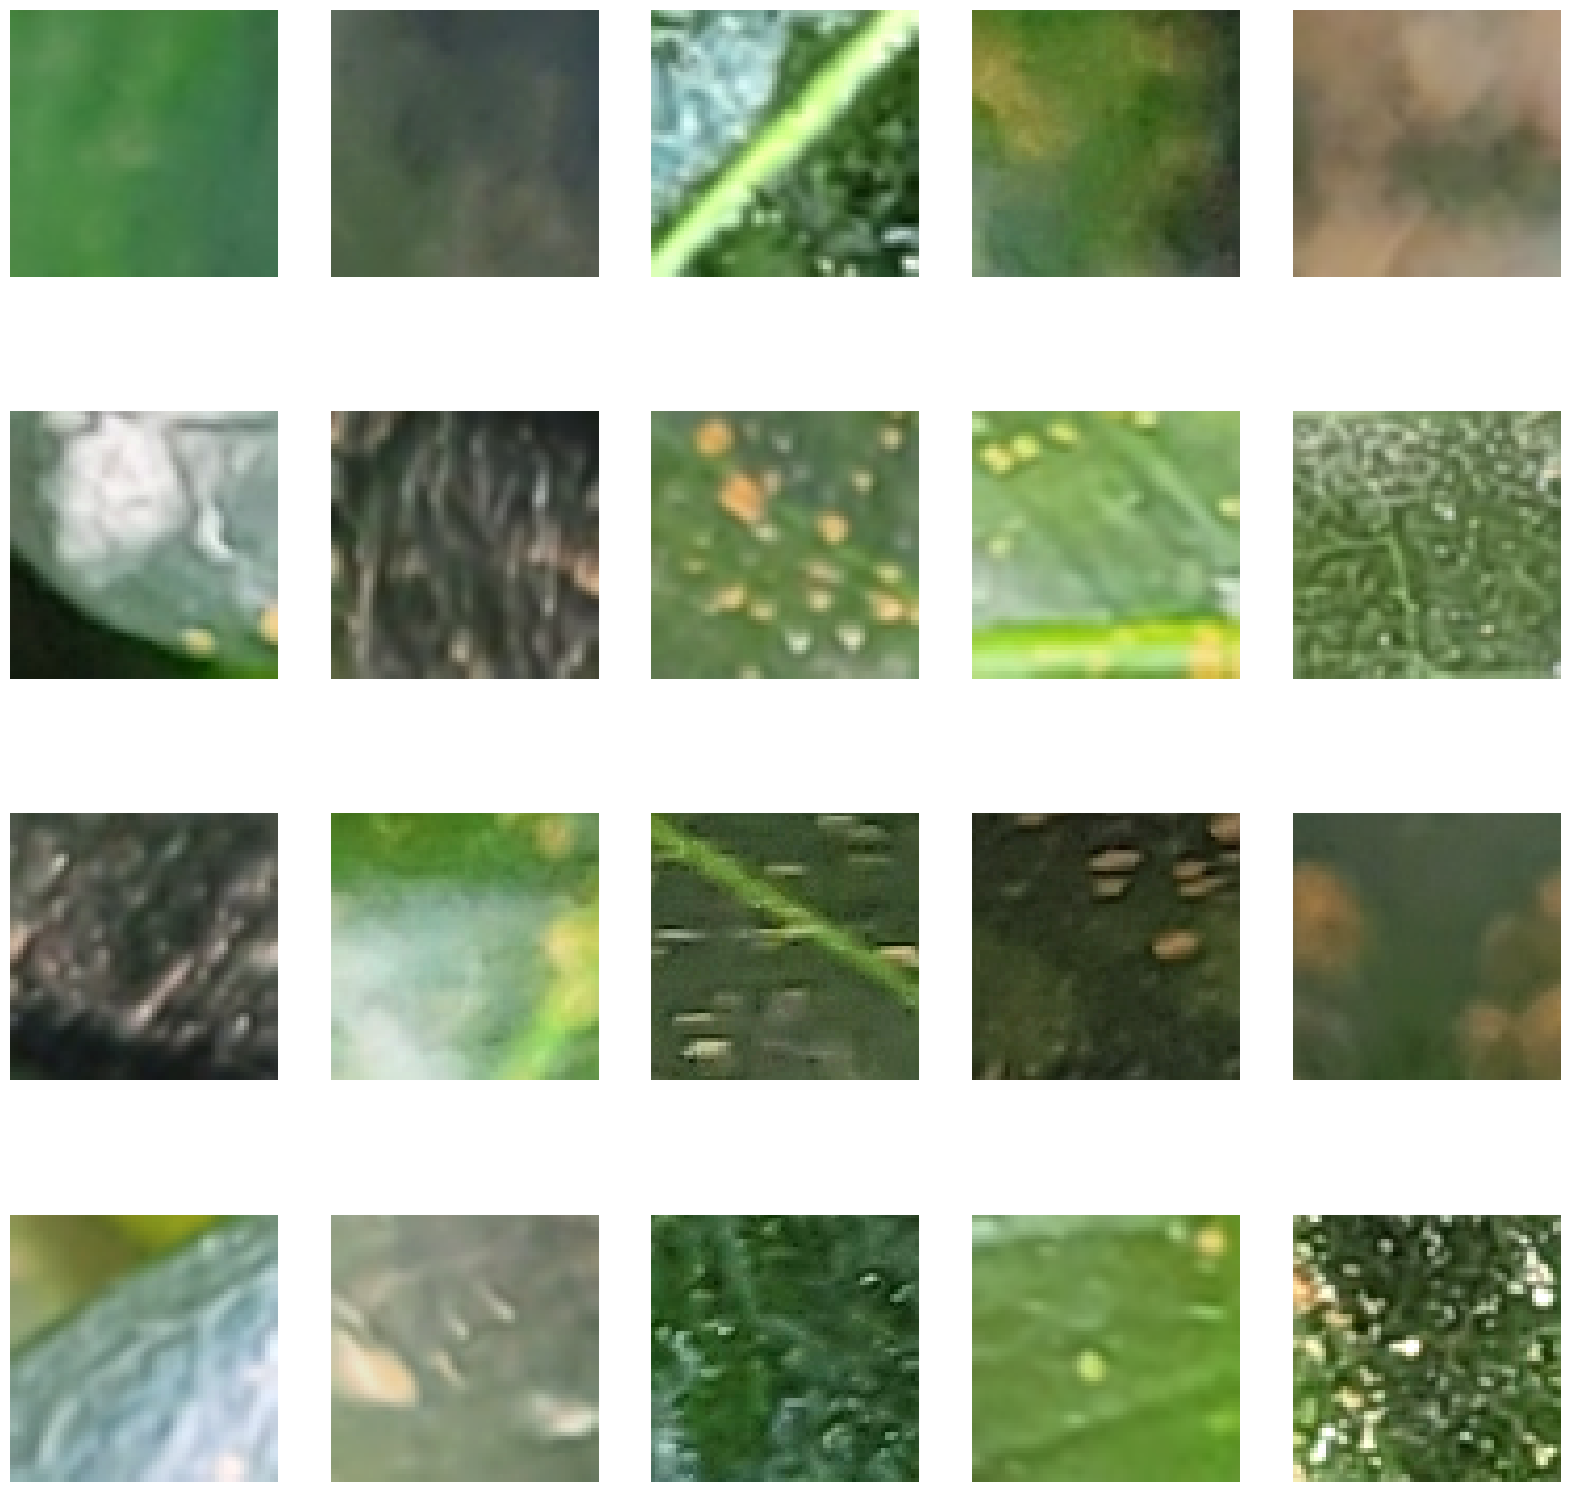

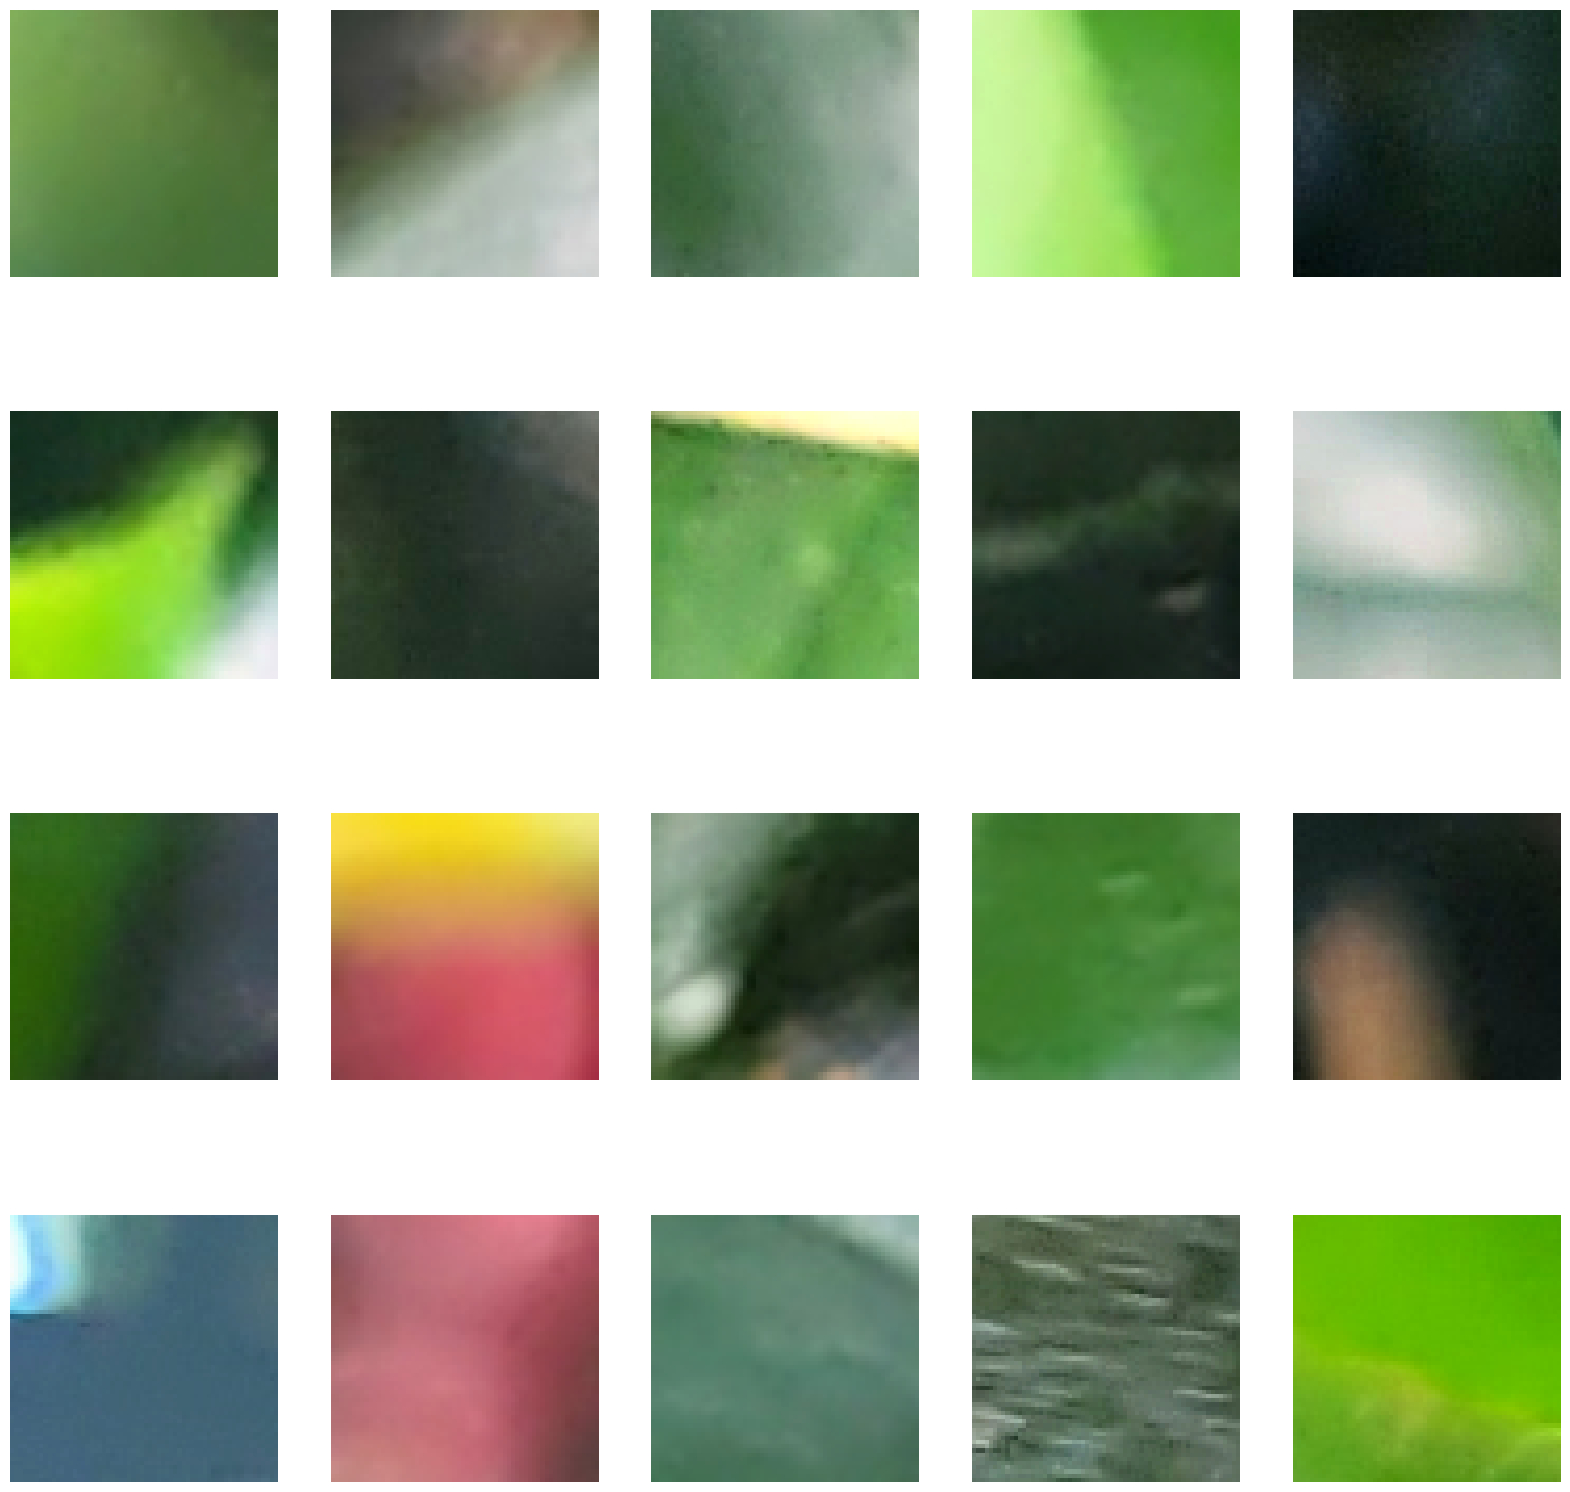

In [70]:
import matplotlib.pyplot as plt

sample = adf[adf['rust'] == 1].sample(20)

fig, ax = plt.subplots(4, 5, figsize=(20, 20))
ax = ax.flatten()
index = 0
for _, row in sample.iterrows():
    ax[index].imshow(row['cropped'])
    ax[index].axis('off')
    index += 1
plt.show()

sample = adf[adf['rust'] == 0].sample(20)

fig, ax = plt.subplots(4, 5, figsize=(20, 20))
ax = ax.flatten()
index = 0
for _, row in sample.iterrows():
    ax[index].imshow(row['cropped'])
    ax[index].axis('off')
    index += 1
plt.show()

In [71]:
def graph_history_metrics(history):
    cols = 3
    rows = int(np.ceil(len(history.history.keys()) / cols))
    
    height = 5 * rows

    fig, axes = plt.subplots(rows, cols, figsize=(20, height))
    axes = axes.flatten()

    # pad the axes
    fig.tight_layout(pad=3.0)

    fig.suptitle('Model Metrics')

    keys = history.history.keys()

    for i, key in enumerate(keys):
        
        final_val = history.history[key][-1]
        
        axes[i].axhline(final_val, ls='--', color='r')
        axes[i].plot(history.history[key], label=key)
        axes[i].set_title(f'{key}. Final: {final_val:.4f}')
        axes[i].set_xlabel('Epoch')
        axes[i].set_ylabel(key)
        axes[i].legend()


In [72]:
from keras.models import Sequential
from keras.layers import Dense, Conv2D, MaxPooling2D, Flatten
from keras.callbacks import EarlyStopping
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder

model = Sequential()
model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(64, 64, 3)))
model.add(MaxPooling2D((2, 2)))
model.add(Flatten())
model.add(Dense(32, activation='relu'))
model.add(Dense(16, activation='relu'))
model.add(Dense(2, activation='softmax'))
model.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['accuracy', 'AUC', 'Precision', 'Recall']
)

x = np.stack(adf['cropped'].values)
y = adf['rust'].values

x_train, x_test, y_train, y_test = train_test_split(x, y, random_state=42)

encoder = OneHotEncoder(sparse=False)

y_train = encoder.fit_transform(y_train.reshape(-1, 1))
y_test = encoder.transform(y_test.reshape(-1, 1))

print(x_train.shape)
print(y_train.shape)
print(x_test.shape)
print(y_test.shape)

history = model.fit(
    x_train,
    y_train,
    epochs=50,
    validation_split=0.2,
    callbacks=[
        #EarlyStopping(patience=5)
    ]
)

/home/jack/.local/share/virtualenvs/datadev-5ox7fytP/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:975: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


(5607, 64, 64, 3)
(5607, 2)
(1869, 64, 64, 3)
(1869, 2)
Epoch 1/50
141/141 [==============================] - 3s 18ms/step - loss: 0.5850 - accuracy: 0.7090 - auc: 0.7727 - precision: 0.7090 - recall: 0.7090 - val_loss: 0.4827 - val_accuracy: 0.7906 - val_auc: 0.8554 - val_precision: 0.7906 - val_recall: 0.7906
Epoch 2/50
141/141 [==============================] - 2s 16ms/step - loss: 0.4620 - accuracy: 0.7891 - auc: 0.8665 - precision: 0.7891 - recall: 0.7891 - val_loss: 0.4541 - val_accuracy: 0.7906 - val_auc: 0.8774 - val_precision: 0.7906 - val_recall: 0.7906
Epoch 3/50
141/141 [==============================] - 2s 17ms/step - loss: 0.4367 - accuracy: 0.8065 - auc: 0.8800 - precision: 0.8065 - recall: 0.8065 - val_loss: 0.4575 - val_accuracy: 0.7888 - val_auc: 0.8695 - val_precision: 0.7888 - val_recall: 0.7888
Epoch 4/50
141/141 [==============================] - 2s 17ms/step - loss: 0.4305 - accuracy: 0.8138 - auc: 0.8836 - precision: 0.8138 - recall: 0.8138 - val_loss: 0.4945 - 

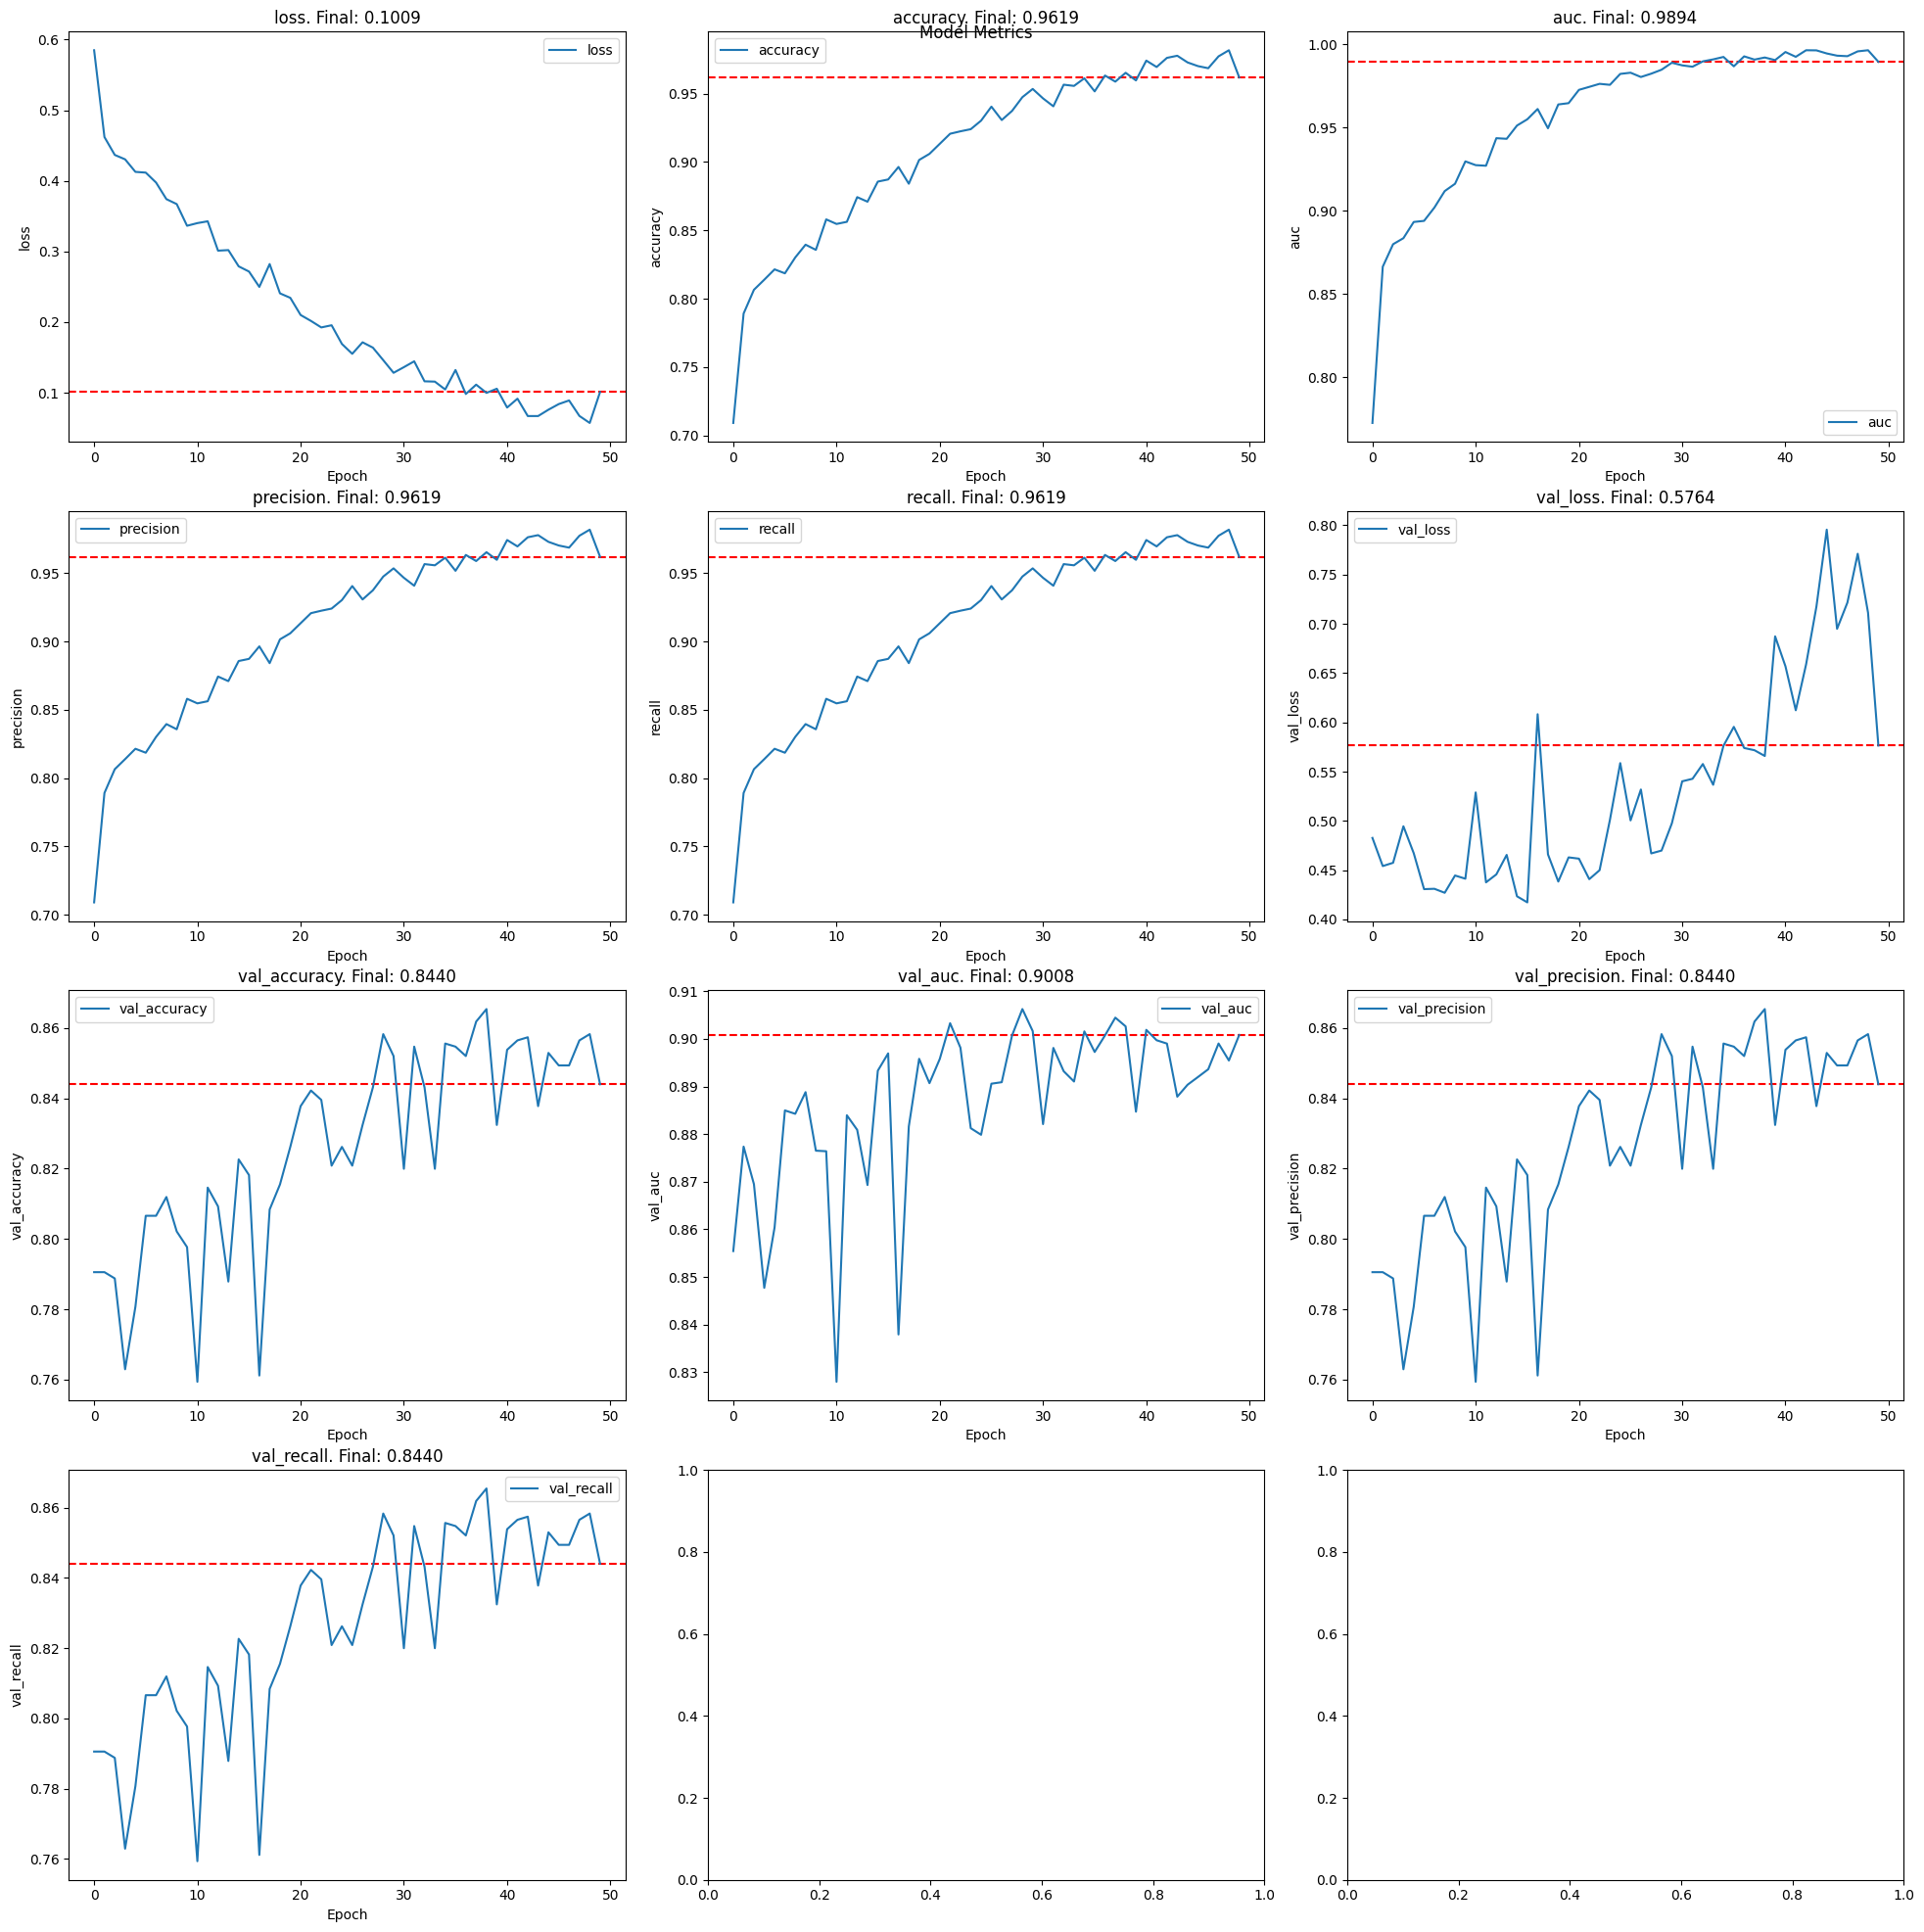

In [73]:
graph_history_metrics(history)

In [74]:
from sklearn.metrics import classification_report

print(classification_report(
    y_test.argmax(axis=1),
    model.predict(x_test).argmax(axis=1),
    labels=[0, 1],
    target_names=['healthy', 'rust']
))

59/59 [==============================] - 0s 4ms/step
              precision    recall  f1-score   support

     healthy       0.84      0.88      0.86       932
        rust       0.87      0.83      0.85       937

    accuracy                           0.85      1869
   macro avg       0.85      0.85      0.85      1869
weighted avg       0.85      0.85      0.85      1869



In [ ]:
# a higher recall than precision means that the model is more likely to predict a 
# positive result when it is actually negative

3024it [28:45,  1.75it/s]


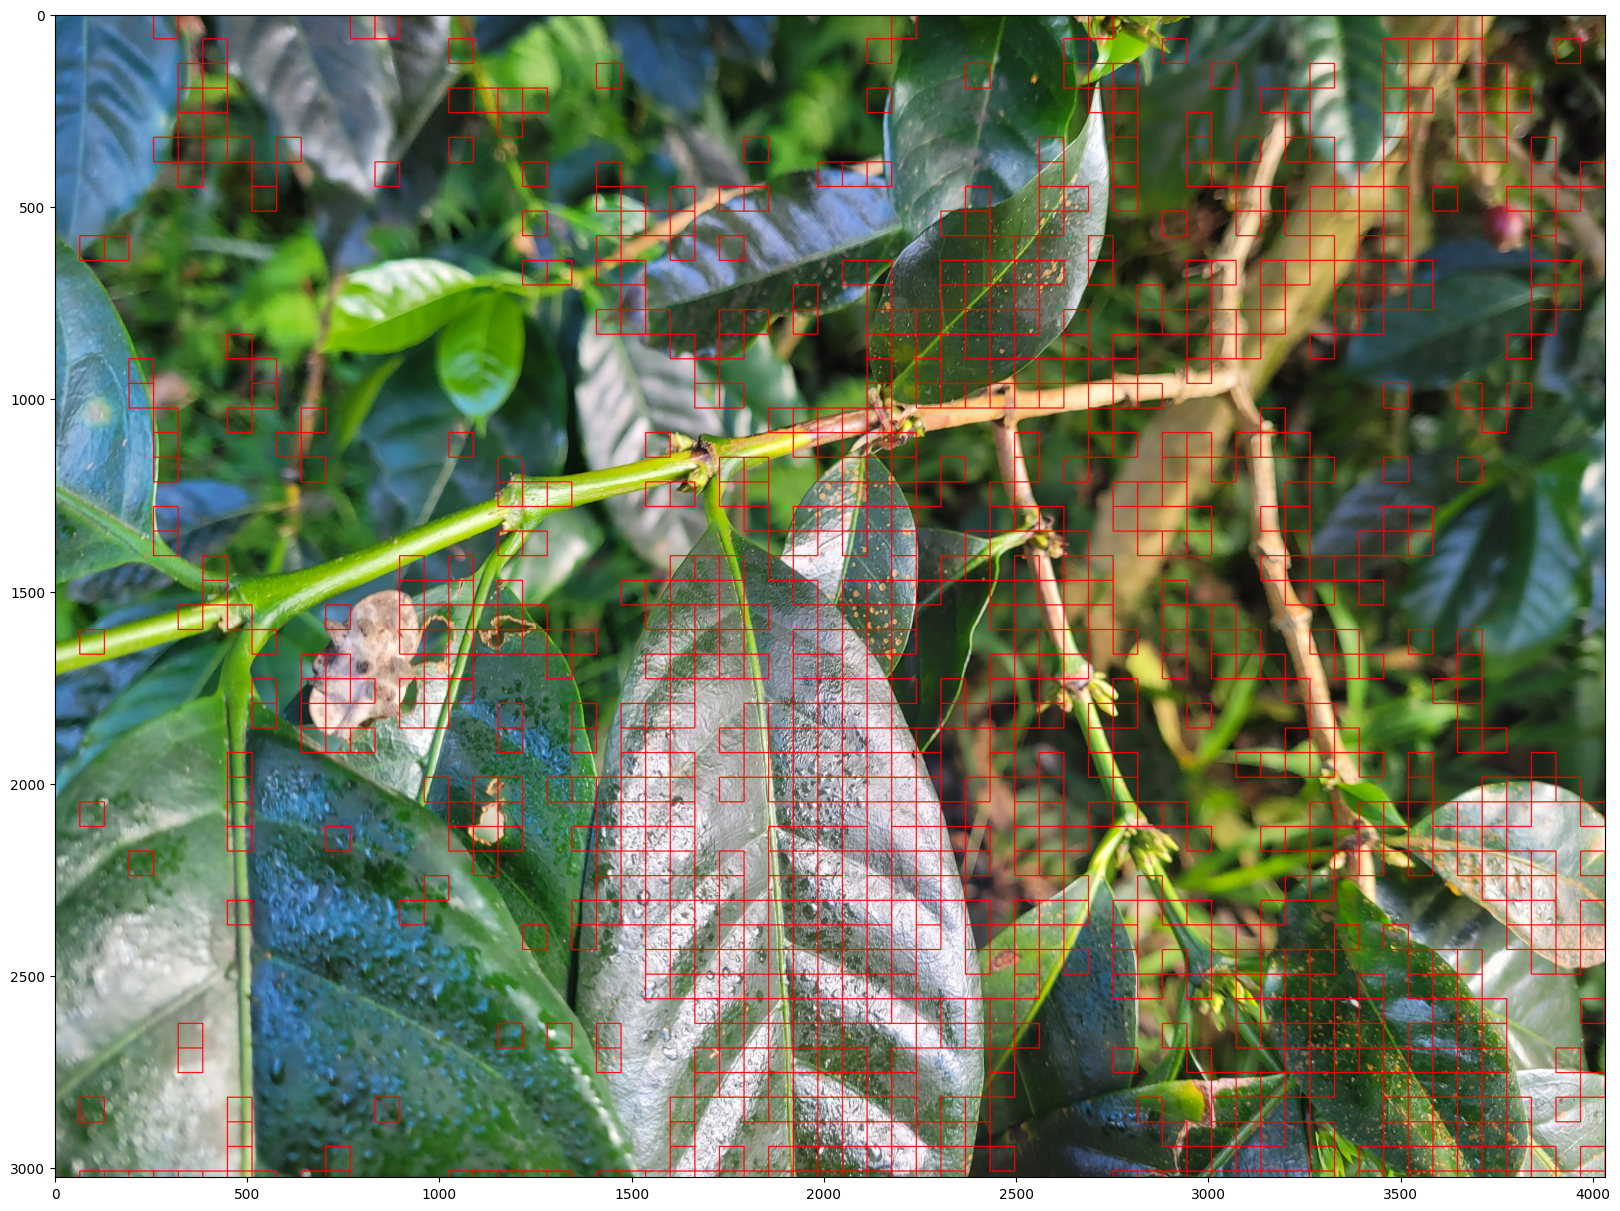

In [75]:
path = '/home/jack/Mounts/RemoteS3/kona_coffee_images/leaves/03-12-2023'

image_paths = os.listdir(path)
image_path = image_paths[np.random.randint(0, len(image_paths))]

full_image = cv2.imread(os.path.join(path, image_path))
full_image = cv2.cvtColor(full_image, cv2.COLOR_BGR2RGB)

image = Image.open(os.path.join(path, image_path)).convert('RGB')

box_size = 64
x = 0
y = 0

loader = tqdm(total=(image.height // box_size) * (image.width // box_size))

# for each box, predict the probability of rust
predictions = []

while y < image.height:
    while x < image.width:
        cropped = image.crop((x, y, x + box_size, y + box_size))
        cropped = np.array(cropped) / 255.0
        
        results = model.predict(cropped.reshape(1, 64, 64, 3), verbose=False)
        
        predictions.append((results[0][1], x, y, box_size))
        
        if results[0][1] > 0.5:
            cv2.rectangle(full_image, (x, y), (x + box_size, y + box_size), (255, 0, 0), 2)
        
        loader.update(1)
        
        x += box_size
    y += box_size
    x = 0

plt.figure(figsize=(20, 20))
plt.imshow(full_image)

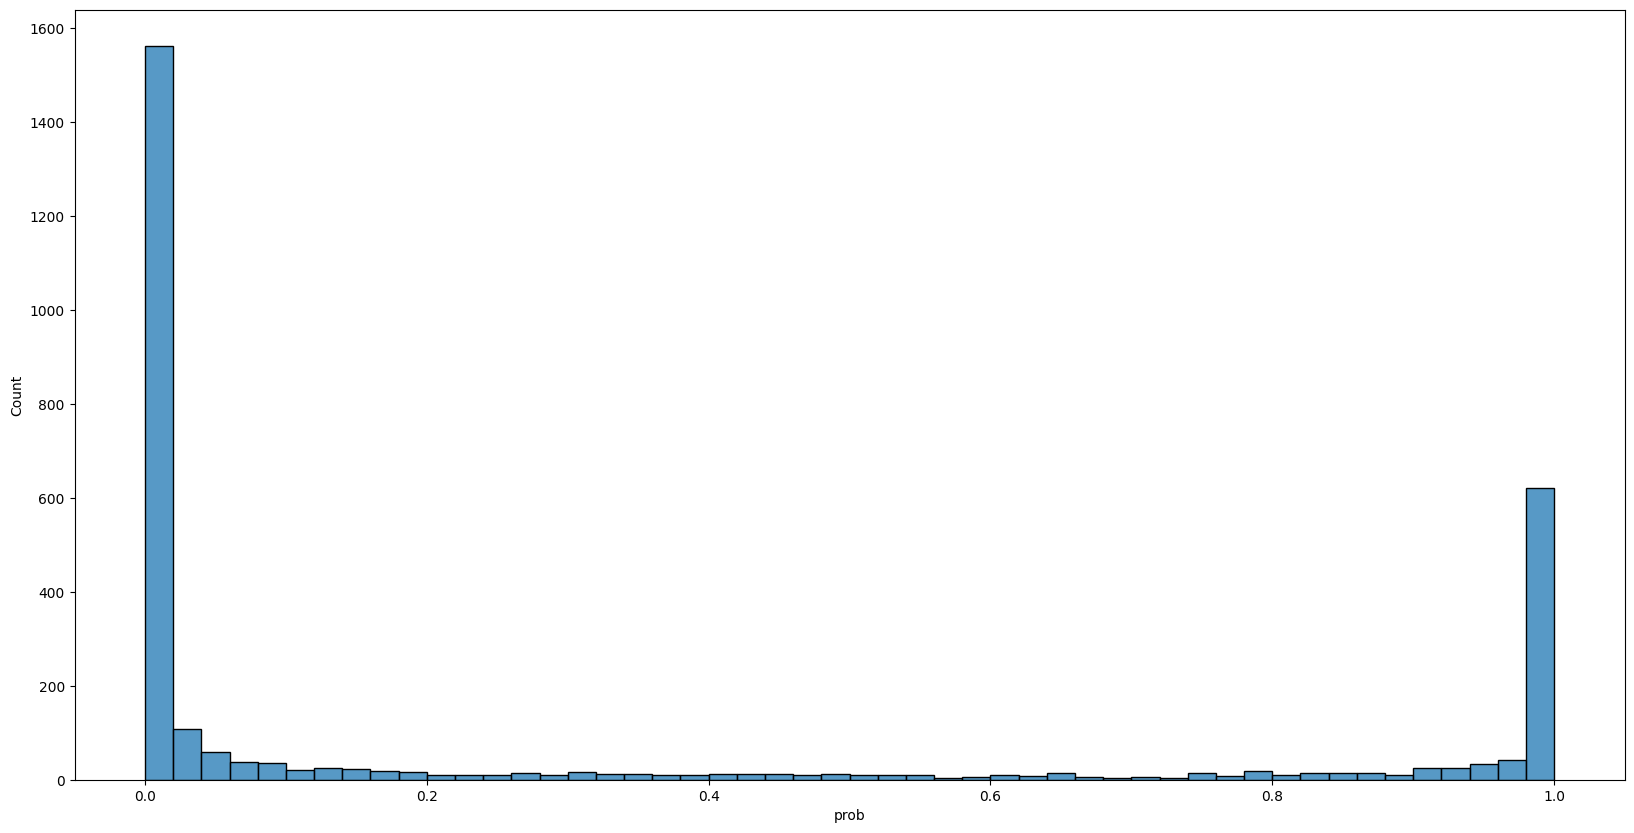

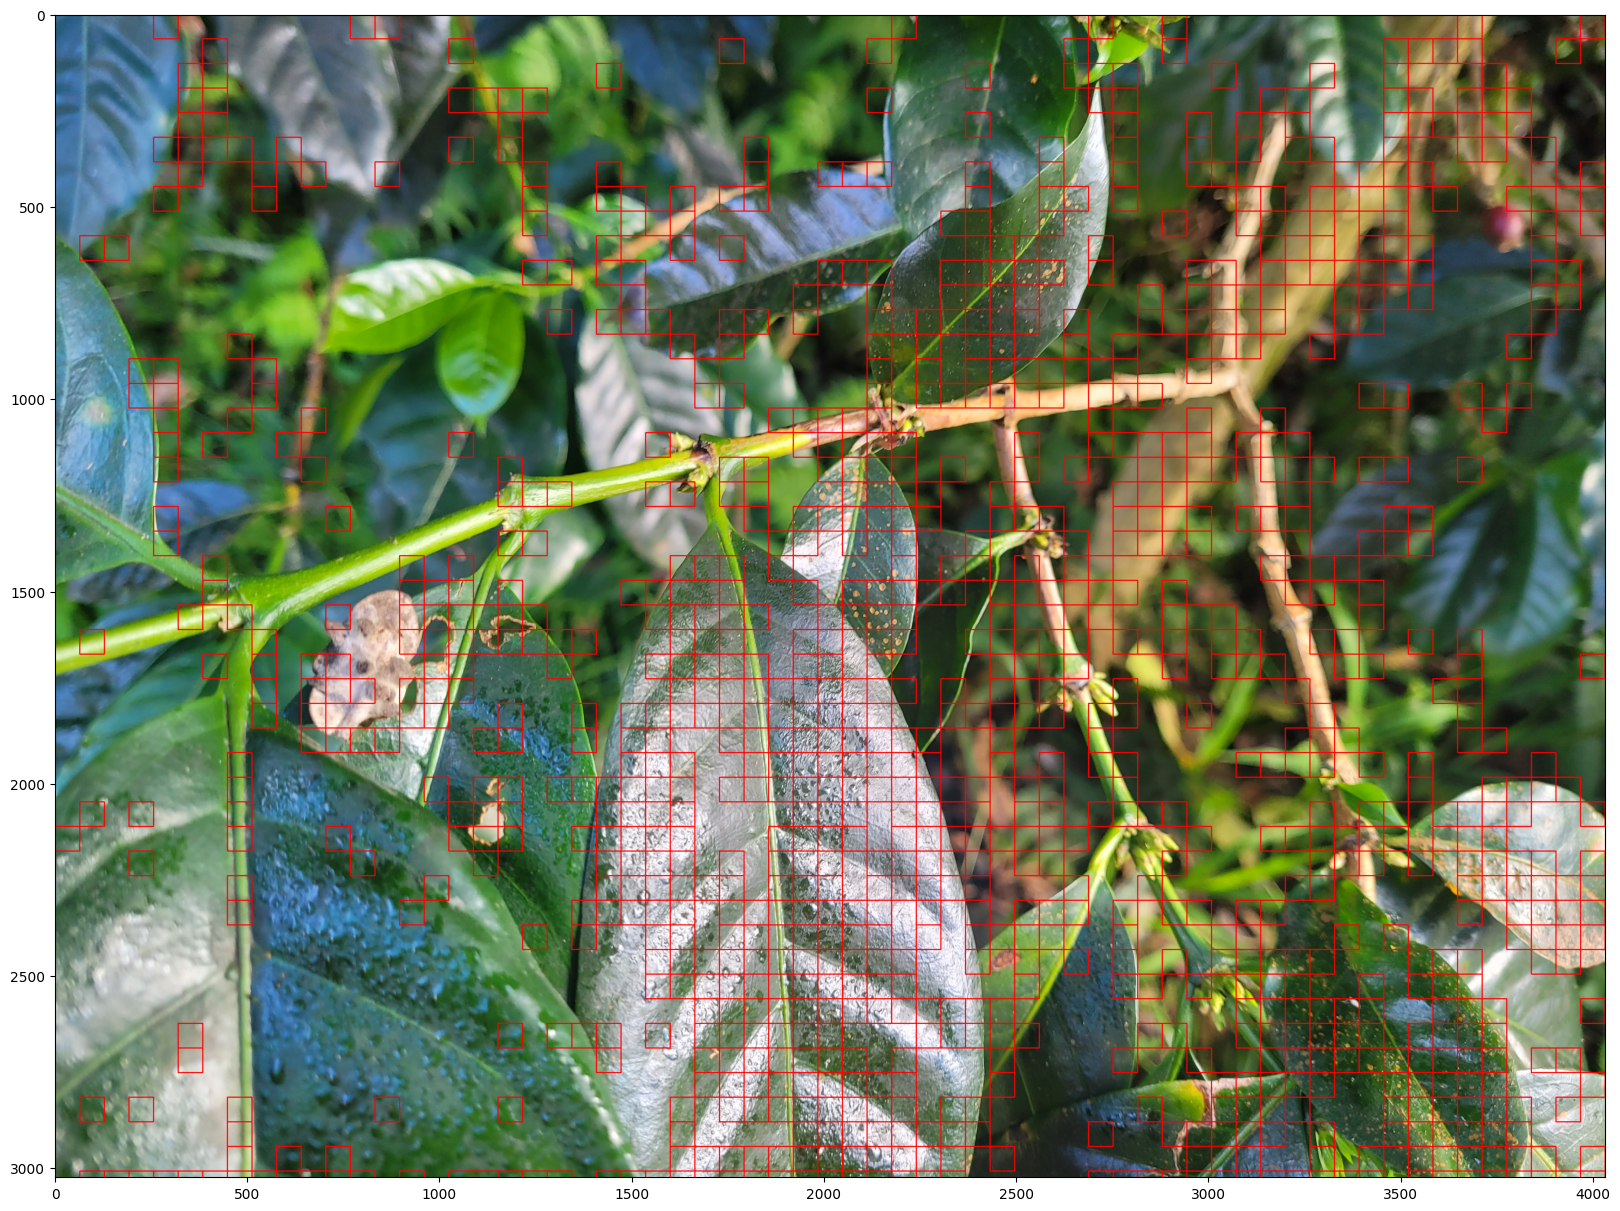

In [77]:
pdf = pd.DataFrame(predictions, columns=['prob', 'x', 'y', 'size'])

# histogram of probabilities

plt.figure(figsize=(20, 10))
sns.histplot(pdf['prob'], bins=50)

for row in pdf.itertuples():
    if row.prob > 0.95:
        cv2.rectangle(full_image, (row.x, row.y), (row.x + row.size, row.y + row.size), (255, 0, 0), 2)
        
plt.figure(figsize=(20, 20))
plt.imshow(full_image)